# Радиолокационные данные
***

Для упрощения работы и анализа радиолокационных данных существует множество открытых библиотек на github. Однако есть наиболее оконченная такая как ```openradar```. Вся дальнейшая работа основана на наработках данного репозитория.
```python 
!pip install openradar # Библиотека для работы с радаром
import mmwave as mm    # импорт библиотеки для работы с радаром
```
Ссылка на github репозиторий: [OpenRadar on github](https://github.com/PreSenseRadar/OpenRadar)  
Ссылка на документацию модуля: [Welcome to the mmwave docs!](https://openradar.readthedocs.io/en/latest/)

## Введение

### Как радар считывает данные

Сначала радар посылает известные ЛЧМ сигналы с использованием одного или нескольких передатчиков. Затем он ожидает, пока эти сигналы не будут прерваны объектами на пути и не отразятся обратно. Дальше радар использует свой приемник или приемники для считывания сигналов в виде аналоговых значений и оцифровки их в типы данных, с которыми мы можем работать (например, int16) с помощью АЦП.

### Упорядочивание данных

Выборка АЦП в данном контексте представляет собой буквальное преобразование принятой электромагнитной волны в цифровой сигнал.

Выборки АЦП хранятся в последовательностях, которые сопоставляются с одним ЛЧМ сигналом. Например, после отправки сигнала, радар может быть сконфигурирован для "тестирования" принятого сигнала 256 раз в течение заданного промежутка времени с равными интервалами выборки.

Один кадр содержит информацию, полученную путем излучения радаром группы из нескольких сигналов. По сути, после выборки одного ЛЧМ мы можем выполнить выборку дополнительных ЛЧМ и сложить результат столько раз, сколько захотим.

Поскольку теперь у вас есть базовое представление о данных, с которыми мы будем работать, теперь мы можем перейти к их использованию. В следующих нескольких модулях "основы" мы поговорим о том, как извлечь важную информацию из этих данных.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path2file = 'data/adc_data.bin';

numRX = 4;
numADCSamples = 256;
numADCBits = 16;

In [3]:
with open(path2file, 'rb') as file:
    read_data = np.array(np.frombuffer(file.read(), dtype = np.int16));
fileSize = read_data.shape[0];

In [4]:
if numADCBits != 16:
    l_max = 2**(numADCBits - 1) - 1;
    read_data[read_data > l_max] -= 2 ** numADCBits;

In [5]:
# for complex data
# filesize = 2 * numADCSamples * numChirps
numChirps = int(fileSize / 2 / numADCSamples / numRX);
LVDS = np.zeros(int(fileSize / 2), dtype = np.complex128);
# combine real and imaginary part into complex data
# read in file: 2I is followed by 2Q
LVDS[::2] = read_data[::4] + 1j * read_data[2::4];
LVDS[1::2] = read_data[1::4] + 1j * read_data[3::4];
# create column for each chirp
# each row is data from one chirp
LVDS = np.reshape(LVDS, (numADCSamples * numRX, numChirps), order = 'F').transpose();
# organize data per RX
adcData = np.zeros((numRX, numChirps * numADCSamples), dtype = np.complex128);

In [6]:
for row in range(numRX):
    for i in range(numChirps):
        adcData[row, i * numADCSamples:((i + 1) * numADCSamples)] = LVDS[i, row * numADCSamples:((row + 1) * numADCSamples)];
print(f'adc_data shape : {adcData.shape}');

adc_data shape : (4, 33554432)


In [7]:
numFrames = numChirps // numADCSamples * 2;
numChirps_per_frame = fileSize // (numChirps * numADCSamples) * numADCBits;

print(f'Число расчитанных кадров: {numFrames}');
print(f'Число расчитанных ЛЧМ в одном кадре: {numChirps_per_frame}');

Число расчитанных кадров: 1024
Число расчитанных ЛЧМ в одном кадре: 128


In [8]:
num = 0;

sb = adcData[0, numADCSamples * num:numADCSamples * (num + 1)];
# np.save('data/simple_chirp.npy', sb);

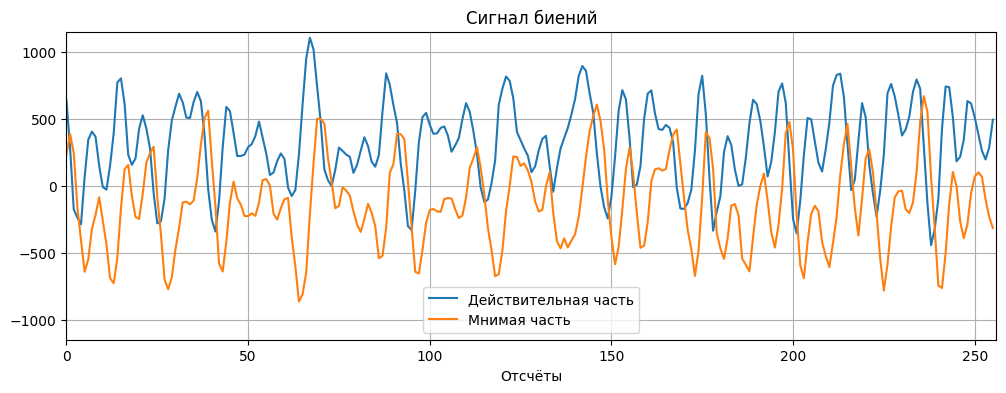

In [12]:
plt.figure(figsize = (12, 4));
plt.title('Сигнал биений');
plt.xlabel('Отсчёты');
# plt.ylabel('Амплитуда');
plt.grid();
plt.axis([0, len(sb), -1 * np.abs(sb).max(), np.abs(sb).max()]);

plt.plot(sb.real);
plt.plot(sb.imag);

plt.legend(['Действительная часть', 'Мнимая часть']);